# Customize a dataset
create a class for the customized dataset

In [1]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from PIL import Image

class fundusisnotfun(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Dataset preparation

We seperate the left/right eyes as two samples and save the labels as csv file

In [2]:
from packages.small_batch_images import *
df = load_annotation()
healthy_labels = pd.DataFrame(columns=['image', 'age'])
unhealthy_labels = healthy_labels.copy()
# Seperate the each healthy sample into two samples
i = 0; j = 0
for ind in df.index:
    row = df.loc[ind]
    # healthy/unhealthy set construction
    if os.path.isfile('images_cropped/{}'.format(row.Left_Fundus)):
        if row.Left_Diagnosis == 'normal fundus':
            healthy_labels.loc[i] = {'image': row['Left_Fundus'], 'age': row['Age']}
            i+=1
        else:
            unhealthy_labels.loc[j] = {'image': row['Left_Fundus'], 'age': row['Age']}
            j+=1
    if os.path.isfile('images_cropped/{}'.format(row.Right_Fundus)):
        if row.Right_Diagnosis == 'normal fundus':
            healthy_labels.loc[i] = {'image': row['Right_Fundus'], 'age': row['Age']}
            i+=1
        else:
            unhealthy_labels.loc[j] = {'image': row['Right_Fundus'], 'age': row['Age']}
            j+=1
# save as csv file
healthy_labels.to_csv('healthy_labels.csv', index=False)
unhealthy_labels.to_csv('unhealthy_labels.csv', index=False)

In [3]:
healthy_labels.head()

,image,age
0,0_right.jpg,69
1,1_left.jpg,57
2,1_right.jpg,57
3,3_left.jpg,66
4,8_left.jpg,59


In [4]:
# for each age there are at least 2 sample (in fact it's L/R eyes)
healthy_labels.groupby('age').count().min()

image    1
dtype: int64

In [5]:
len(healthy_labels)

2547

In [6]:
# Use stratified method to select samples, leave 20% for testing, together with unhealthy ones
healthy_labels = pd.read_csv('healthy_labels.csv')
train = healthy_labels.groupby('age', group_keys=False).apply(lambda x: x.sample(min(len(x), 10)))
test = healthy_labels[~healthy_labels.index.isin(train.index)]
test = pd.concat((test, unhealthy_labels.sample(200)))
train.to_csv('labels_train.csv', index=False)
test.to_csv('labels_test.csv', index=False)
(len(train), len(test))

(569, 2178)

##### For inital test only

array([[<Axes: title={'center': 'age'}>]], dtype=object)

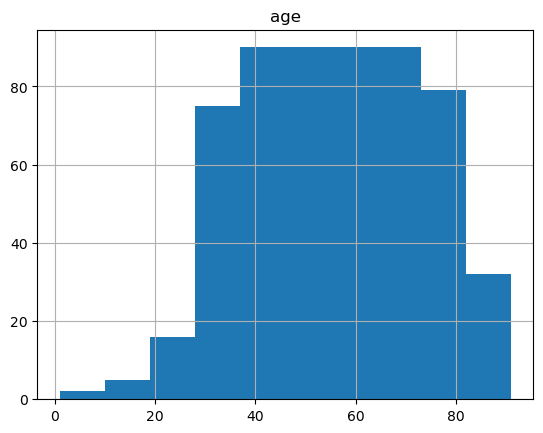

In [7]:
train.hist()

In [25]:
train = train.sample(200)
test = test.sample(100)

array([[<Axes: title={'center': 'age'}>]], dtype=object)

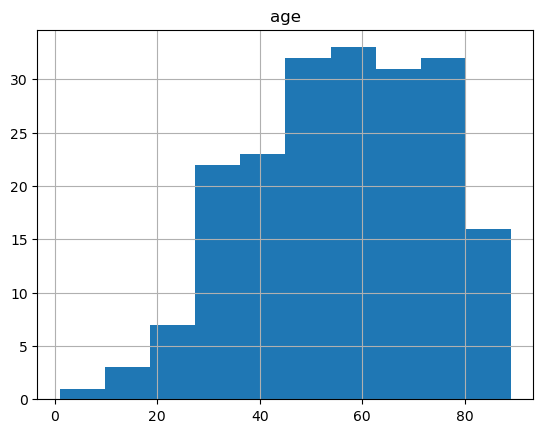

In [26]:
train.hist()

Datasets creation

In [78]:
# Function to calculate mean and std
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data)
        channels_squared_sum += torch.mean(data**2)
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std

Feature batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


C:\Users\Admin\AppData\Local\Temp\ipykernel_3356\3721721370.py:40: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  plt.imshow(img.T)


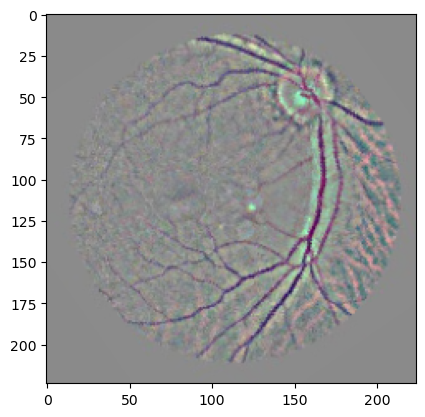

Label: 63


In [8]:
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

plain_transform = T.Compose([
        T.ToTensor(),
])
        # T.Normalize(list(mean), list(std))])

training_data_plain = fundusisnotfun(img_dir='images_cropped', transform=plain_transform, annotations_file='labels_train.csv')
test_data = fundusisnotfun(img_dir='images_cropped', transform=plain_transform,annotations_file='labels_test.csv')

train_loader_plain = DataLoader(training_data_plain, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)
# start augmentation
color_jitter = T.ColorJitter(brightness=0.2, contrast=0.1)
train_transform_augs = T.Compose([
        T.ToTensor(),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation([0, 180], fill=0.5),
        T.RandomResizedCrop(size=224, scale=(0.9,1),antialias=True),
        T.RandomApply([color_jitter], p=0.8),
])
        # T.Normalize(list(mean), list(std))])

training_data = fundusisnotfun(img_dir='images_cropped', transform=train_transform_augs, annotations_file='labels_train.csv')
train_loader = DataLoader(training_data, batch_size=128, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T)
plt.show()
print(f"Label: {label}")

In [9]:
train_features.shape

torch.Size([128, 3, 224, 224])

# Transfer Learning models

## ResNet

In [10]:
import numpy as np
import torch
import torchvision
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from torch import nn

device = 'cuda'

In [11]:
import packages.utils
from packages.utils import *
import importlib
importlib.reload(packages.utils)

<module 'packages.utils' from 'c:\\Users\\Admin\\Documents\\GitHub\\fundusfunfunf\\packages\\utils.py'>

In [16]:
# create model
class ResSoftMax(nn.Module):
    # def __init__(self):
    #     super(ResSoftMax, self).__init__()
    #     ### START CODE HERE ### (approx. 3 lines)
    #     # self.backbone = model_driu
    #     self.backbone = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
    #     # self.backbone = torchvision.models.resnet50()
    #     # self.backbone = torchvision.models.vgg16(weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1)
    #     for param in self.backbone.parameters():
    #         param.requires_grad = False
    #     self.backbone.fc = nn.Linear(512, 100)
    #     self.backbone.sm = nn.Softmax(dim=0)
    #     for param in self.backbone.fc.parameters():
    #         param.requires_grad = True

    #     ### END CODE HERE ###
    def __init__(self):
        super(ResSoftMax, self).__init__()
        ### START CODE HERE ### (approx. 3 lines)
        self.backbone = torchvision.models.resnet101(weights = torchvision.models.ResNet101_Weights.DEFAULT)
        # self.backbone = torchvision.models.resnet50()
        # self.backbone = torchvision.models.vgg16(weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.backbone.fc = nn.Identity()
        self.addition = nn.Sequential(
            # nn.AvgPool2d(kernel_size=12),
            nn.Linear(in_features=2048, out_features=1),
            # nn.Softmax()
        )
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (approx. 1 lines)
        out = self.addition((self.backbone(x)))
        return out
        ### END CODE HERE ###

    # def forward(self, x):
    #     ### START CODE HERE ### (approx. 1 lines)
    #     out = self.backbone(x)
    #     return out
    #     ### END CODE HERE ###

# Initialize model and optimizer
num_epochs = 50
### START CODE HERE ### (approx. 2 lines)
model = ResSoftMax()
# model = model_driu

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.01, betas=(0.9, 0.999))
### END CODE HERE ###

dict_log = train(model, optimizer, num_epochs, train_loader, test_loader, device)

Init MAE of the model: Train:55.109 	 Val:57.978165


Ep 49/50: MAE : Train:54.24 	 Val:            57.09 || Loss: Train 53.629 	 Val 56.849            || Corr: Train -9.610 	 Val -38.360: 100%|██████████| 50/50 [1:22:22<00:00, 98.85s/it] 


In [41]:
figsize = (15,10)
plt.figure(figsize=figsize)
plot_stats(dict_log, baseline=3.3, modelname="Resnet50 + MLP fine-tuning")
# plt.savefig(fname="./figs/mlp_resnet50_finetune_embeds.png", dpi=500, bbox_inches='tight')
plt.show()

NameError: name 'dict_log' is not defined

<Figure size 1500x1000 with 0 Axes>

In [145]:
type(model_driu)

torch.nn.modules.container.Sequential

In [38]:
from torchsummary import summary
summary(model, (3, 512, 512))

AttributeError: 'torch.Size' object has no attribute 'size'

In [131]:
for module in model_driu:
    print(module)

TorchVisionNormalizer()
VGG4Segmentation(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_si